<a href="https://colab.research.google.com/github/shaangao/neural-net-pos-tagging/blob/main/NNPOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import pandas as pd
import joblib
import math
from copy import deepcopy

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

## load raw datasets

### load tweets

In [13]:
# func to load_dataset into a list of lists of (word, tag) tuples (each inner list is a tweet)

def load_dataset(data_path):

    tweets = []
    vocab = set()
    tags = set()

    with open(data_path, 'r') as file:

        tweet = []

        for i, line in enumerate(file):

            # if line is empty, store current tweet and start a new tweet
            if line in ['\n']:
                tweets.append(tweet)
                tweet = []

            # otherwise, append new word and tag to current tweet as a tuple
            else:
                word, tag = line.strip('\n').split('\t')  # split string into word and tag
                vocab.add(word)
                tags.add(tag)
                tweet.append((word, tag))

    return tweets, vocab, tags

In [14]:
# load datasets

twpos_train, vocab_train, tags_train = load_dataset('/content/drive/MyDrive/postag/data/twpos-data/twpos-train.tsv')
twpos_dev, vocab_dev, tags_dev = load_dataset('/content/drive/MyDrive/postag/data/twpos-data/twpos-dev.tsv')
twpos_devtest, vocab_devtest, tags_devtest = load_dataset('/content/drive/MyDrive/postag/data/twpos-data/twpos-devtest.tsv')

print(f'twpos_train: {len(twpos_train)}, vocab_train: {len(vocab_train)}\ntwpos_dev: {len(twpos_dev)}, vocab_dev: {len(vocab_dev)}\ntwpos_devtest: {len(twpos_devtest)}, vocab_devtest: {len(vocab_devtest)}')

twpos_train: 1173, vocab_train: 4420
twpos_dev: 327, vocab_dev: 1750
twpos_devtest: 327, vocab_devtest: 1705


In [15]:
# get all_vocab in train, dev, and devtest
all_vocab = list(vocab_train.union(vocab_dev).union(vocab_devtest))
all_vocab += ['<s>', '</s>']   # add beginning and end of sentence markers
print(len(all_vocab))

# get all_tags in train, dev, and devtest
all_tags = list(tags_train.union(tags_dev).union(tags_devtest))
print(len(all_tags))

5991
25


In [16]:
# load orig datasets

orig_train, _, _ = load_dataset('/content/drive/MyDrive/postag/data/twpos-data/orig-train.tsv')
orig_dev, _, _ = load_dataset('/content/drive/MyDrive/postag/data/twpos-data/orig-dev.tsv')
orig_devtest, _, _ = load_dataset('/content/drive/MyDrive/postag/data/twpos-data/orig-devtest.tsv')

print(f'orig_train: {len(orig_train)}\norig_dev: {len(orig_dev)}\norig_devtest: {len(orig_devtest)}')

orig_train: 1173
orig_dev: 327
orig_devtest: 327


### load embeddings

In [17]:
# load pretrained embeddings

emb_pretrained_vocab = []
emb_pretrained = []

with open('/content/drive/MyDrive/postag/data/twitter-embeddings.txt', 'r') as file:

  for i, line in enumerate(file):

    line_split = line.strip().split()

    emb_pretrained_vocab.append(line_split[0])
    emb_pretrained.append(list(map(float, line_split[1:])))

emb_pretrained = torch.tensor(emb_pretrained)
print(len(emb_pretrained_vocab), emb_pretrained.shape)

30001 torch.Size([30001, 50])


## encoders

### word & tag encoders

In [18]:
# func: get idx in emb matrix given a word
def get_word2idx(vocab_list):
  word2idx = {}
  for i, word in enumerate(vocab_list):
    word2idx[word] = i
  return word2idx

In [19]:
# for encoding words in context windows
word2idx_all_vocab = get_word2idx(all_vocab)
word2idx_emb_pretrained_vocab = get_word2idx(emb_pretrained_vocab)
# tag2idx = get_word2idx(all_tags)

In [20]:
# for encoding targets
le = LabelEncoder()
le.fit(all_tags)

LabelEncoder()

### encoded data class

In [21]:
# reference: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html


class POSDataset(Dataset):


    def __init__(self, dataset:list, dataset_orig:list, word2idx:dict, tag2idx:LabelEncoder(), w:int, feature_funcs:list=None):

        """
        wins; center_words; center_words_orig; tags; tags_encoded
        """

        wins = []
        center_words = []
        tags = []
        center_words_orig = []   # from the orig-* files

        # encode context window and center word featuress
        for tweet, tweet_orig in zip(dataset, dataset_orig):

            # process every center word in each tweet
            for i, (word, tag) in enumerate(tweet):

                # center word for curr obs
                center_words.append(word)

                # orig center word for curr obs
                center_words_orig.append(tweet_orig[i][0])

                # target of curr obs
                tags.append(tag)

                # construct win: idx for words in context window
                win = []
                for i in range(i-w, i+w+1):
                    if i < 0:   # if before fist token
                        try: win.append(word2idx['<s>'])
                        except: win.append(word2idx['</s>'])   # if '<s>' not in emb vocab, use emb for '</s>'
                    elif i > len(tweet)-1:    # if after last token
                        win.append(word2idx['</s>'])
                    else:
                        try: win.append(word2idx[tweet[i][0]])
                        except: win.append(word2idx['UUUNKKK'])  # use emb for unknown words
                wins.append(win)

        # encode all target tags
        tags_encoded = tag2idx.transform(tags)

        # data type
        wins = torch.tensor(wins)
        center_words = np.array(center_words)
        center_words_orig = np.array(center_words_orig)
        tags_encoded = torch.tensor(tags_encoded)
        tags = np.array(tags)

        # construct features from center_words_orig using feature_funcs
        if feature_funcs is not None:
            features = np.column_stack([np.vectorize(func)(center_words_orig) for func in feature_funcs])
            wins = torch.cat((wins, torch.tensor(features)), dim=1)

        # set attributes
        self.wins = wins
        self.center_words = center_words
        self.center_words_orig = center_words_orig
        self.tags_encoded = tags_encoded
        self.tags = tags


    def __len__(self):
        return len(self.wins)


    def __getitem__(self, idx):
        return self.wins[idx], self.tags_encoded[idx]

### instantiate encoded datasets

In [22]:
# encode datasets


# w = 0, all vocab encoding
train_w0_allvocab = POSDataset(dataset=twpos_train, dataset_orig=orig_train, word2idx=word2idx_all_vocab, tag2idx=le, w=0, feature_funcs=None)
dev_w0_allvocab = POSDataset(dataset=twpos_dev, dataset_orig=orig_dev, word2idx=word2idx_all_vocab, tag2idx=le, w=0, feature_funcs=None)
devtest_w0_allvocab = POSDataset(dataset=twpos_devtest, dataset_orig=orig_devtest, word2idx=word2idx_all_vocab, tag2idx=le, w=0, feature_funcs=None)

# w = 1, all vocab encoding
train_w1_allvocab = POSDataset(dataset=twpos_train, dataset_orig=orig_train, word2idx=word2idx_all_vocab, tag2idx=le, w=1, feature_funcs=None)
dev_w1_allvocab = POSDataset(dataset=twpos_dev, dataset_orig=orig_dev, word2idx=word2idx_all_vocab, tag2idx=le, w=1, feature_funcs=None)
devtest_w1_allvocab = POSDataset(dataset=twpos_devtest, dataset_orig=orig_devtest, word2idx=word2idx_all_vocab, tag2idx=le, w=1, feature_funcs=None)


# w = 0, pretrained 30k vocab encoding
train_w0_30k = POSDataset(dataset=twpos_train, dataset_orig=orig_train, word2idx=word2idx_emb_pretrained_vocab, tag2idx=le, w=0, feature_funcs=None)
dev_w0_30k = POSDataset(dataset=twpos_dev, dataset_orig=orig_dev, word2idx=word2idx_emb_pretrained_vocab, tag2idx=le, w=0, feature_funcs=None)
devtest_w0_30k = POSDataset(dataset=twpos_devtest, dataset_orig=orig_devtest, word2idx=word2idx_emb_pretrained_vocab, tag2idx=le, w=0, feature_funcs=None)

# w = 1, pretrained 30k vocab encoding
train_w1_30k = POSDataset(dataset=twpos_train, dataset_orig=orig_train, word2idx=word2idx_emb_pretrained_vocab, tag2idx=le, w=1, feature_funcs=None)
dev_w1_30k = POSDataset(dataset=twpos_dev, dataset_orig=orig_dev, word2idx=word2idx_emb_pretrained_vocab, tag2idx=le, w=1, feature_funcs=None)
devtest_w1_30k = POSDataset(dataset=twpos_devtest, dataset_orig=orig_devtest, word2idx=word2idx_emb_pretrained_vocab, tag2idx=le, w=1, feature_funcs=None)

## 1.1 baseline neural network tagger

### model architecture

In [23]:
# references:
# - https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
# - https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
# - https://discuss.pytorch.org/t/how-to-create-mlp-model-with-arbitrary-number-of-hidden-layers/13124/2
# - https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_feedforward_neuralnetwork/
# - https://machinelearningmastery.com/activation-functions-in-pytorch/


class FeedForwardNN(nn.Module):


    def __init__(self, w, vocab_size, emb_dim, nfeatures, layer_sizes:list, layer_acts:list, pretrained_emb=None, emb_freeze=False):

        # call parent constructor
        super(FeedForwardNN, self).__init__()

        # set initial embeddings
        if pretrained_emb is not None:
            self.emb = nn.Embedding.from_pretrained(pretrained_emb, freeze=emb_freeze)
        else:   # randomly init embeddings
            self.emb = nn.Embedding(vocab_size, emb_dim)
            self.emb.weight.data.uniform_(-0.01, 0.01)

        # set embeddings' dimensionality
        self.emb_dim = self.emb.weight.shape[1]

        # set total num of words in win
        self.w = 1 + 2 * w

        # set input layer dimensionality
        in_size = self.emb_dim * self.w + nfeatures

        # construct layers (last layer is output layer)
        self.layers = nn.ModuleList()
        for i, layer_size in enumerate(layer_sizes):
            if i == 0:
                layer = nn.Linear(in_size, layer_size)
                layer.weight.data.uniform_(-0.01, 0.01)
                layer.bias.data.zero_()
                self.layers.append(layer)
                # self.layers.append(nn.Linear(in_size, layer_size))
            else:
                layer = nn.Linear(layer_sizes[i-1], layer_size)
                layer.weight.data.uniform_(-0.01, 0.01)
                layer.bias.data.zero_()
                self.layers.append(layer)
                # self.layers.append(nn.Linear(layer_sizes[i-1], layer_size))

        # set each layer's activation function
        self.layer_acts = layer_acts


    def forward(self, x):

        # print('before', x.shape, x[:, :self.w], x[:, self.w:])

        # retrieve context word embeddings and concat horizontally; concat additional features to the right
        x = torch.cat(
            (
                self.emb(x[:, :self.w]).view((x.shape[0], -1)),   # word embeddings
                x[:, self.w:]     # additional features
            ),
            dim=1
        )

        # print('after', x.shape)

        # forward pass
        for i, layer in enumerate(self.layers):
            x = layer(x)
            x = self.layer_acts[i](x)

        return x

### train and eval func

In [24]:
# run one epoch of training

def train1epoch(model, optimizer, criterion, train_dataloader):

    # turn on training mode
    model.train()

    # reset epoch_loss tracker
    epoch_loss = 0

    # iterate through mini-batches
    for xtrain_batch, ytrain_batch in train_dataloader:

        optimizer.zero_grad()   # zero the gradient buffers
        output = model(xtrain_batch)
        loss = criterion(output, ytrain_batch)
        loss.backward()
        optimizer.step()   # does the update

        epoch_loss += loss.item()

    print(f'  epoch loss: {epoch_loss}')
    return epoch_loss

In [25]:
# eval

def eval(model, eval_data):

    # turn on eval mode
    model.eval()

    # turn off gradient calc to reduce memory consumption
    with torch.no_grad():

        # get model predictions on eval_data
        ypred = torch.argmax(model(eval_data.wins), dim=1)

        # count correct predictions
        ycorrect = torch.sum(torch.eq(ypred, eval_data.tags_encoded)).item()

        # total num of obs in eval_data
        ytotal = len(eval_data.tags_encoded)

        # compute accuracy
        yaccu = ycorrect / ytotal

    print(f'  accuracy: {yaccu}')
    return yaccu

### train & eval wrapper

In [26]:
# wrapper for train & eval
# reference: https://pytorch.org/tutorials/beginner/saving_loading_models.html

def main_process(model, name, optimizer, criterion, train_data, batch_size, shuffle, val_data, test_data, max_epochs=10, early_stopping=3):


    # create batched iterator for train_data
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)


    # initialize vars: track metrics
    epoch_losses = []
    train_evals = []
    dev_evals = []

    # initialize vars: track best model
    best_dev_eval = 0
    best_model_epoch = -1

    # train and eval
    for epoch in range(max_epochs):

        print(f'epoch {epoch+1}')

        # train
        epoch_loss = train1epoch(
                          model=model,
                          optimizer=optimizer,
                          criterion=criterion,
                          train_dataloader=train_dataloader
                    )
        epoch_losses.append(epoch_loss)

        # eval on training set
        train_eval = eval(model=model, eval_data=train_data)
        train_evals.append(train_eval)

        # eval on dev set
        dev_eval = eval(model=model, eval_data=val_data)
        dev_evals.append(dev_eval)

        # update best model based on dev eval
        if dev_eval > best_dev_eval:

            # save state_dict of best model so far
            torch.save(model.state_dict(), '/content/drive/MyDrive/postag/models/'+name+'_best.pth.tar')

            # update which epoch best_model is from
            best_model_epoch = epoch

            # update best_dev_accu
            best_dev_eval = dev_eval

        print(f'  best model from epoch {best_model_epoch+1}')

        # early stopping based on dev eval
        if early_stopping is not None:
            if epoch - best_model_epoch >= early_stopping:
                print('========= EARLY STOPPING =========')
                break


    # load state_dict of best model (modifies input model in place)
    print(f'load best model')
    model.load_state_dict(torch.load('/content/drive/MyDrive/postag/models/'+name+'_best.pth.tar'))

    # eval best model on devtest set
    print(f'eval best model on devtest')
    devtest_eval = eval(model=model, eval_data=test_data)


    return epoch_losses, train_evals, dev_evals, devtest_eval


### run model: w=0, all vocab

In [27]:
# instantiate model: single hidden layer 128 with tanh nonlinearity, w=0, all vocab (random init)
tagger_w0 = FeedForwardNN(w=0, vocab_size=len(all_vocab), emb_dim=50, nfeatures=0,
                          layer_sizes=[128, len(all_tags)],  # last layer is the output layer
                          layer_acts=[nn.Tanh(), nn.Identity()],   # nn.CrossEntropyLoss() already includes softmax transformation
                          pretrained_emb=None, emb_freeze=False)

# instantiate optimizer
sgd = optim.SGD(tagger_w0.parameters(), lr=0.02)

# train and eval
epoch_losses, train_evals, dev_evals, devtest_eval = main_process(
                                          model=tagger_w0,
                                          name='tagger_w0',  # file name used for using checkpoint
                                          optimizer=sgd,
                                          criterion=nn.CrossEntropyLoss(),   # objective: log loss
                                          train_data=train_w0_allvocab,
                                          batch_size=1,
                                          shuffle=True,
                                          val_data=dev_w0_allvocab,
                                          test_data=devtest_w0_allvocab,
                                          max_epochs=20,
                                          early_stopping=3   # when dev eval doesn't improve for 3 consecutive epochs
                                      )

epoch 1
  epoch loss: 46360.52154862881
  accuracy: 0.13736135434909516
  accuracy: 0.13690105787181084
  best model from epoch 1
epoch 2
  epoch loss: 33964.24647471821
  accuracy: 0.5658493870402802
  accuracy: 0.5328769964737606
  best model from epoch 2
epoch 3
  epoch loss: 22743.718198784278
  accuracy: 0.7480443666082895
  accuracy: 0.7033810412777433
  best model from epoch 3
epoch 4
  epoch loss: 14901.21043849986
  accuracy: 0.8575014594279042
  accuracy: 0.750674133997096
  best model from epoch 4
epoch 5
  epoch loss: 11242.088181002444
  accuracy: 0.896322241681261
  accuracy: 0.7598008711885501
  best model from epoch 5
epoch 6
  epoch loss: 8556.753457576851
  accuracy: 0.9193228254524226
  accuracy: 0.7728686994399502
  best model from epoch 6
epoch 7
  epoch loss: 6902.9516340345435
  accuracy: 0.9268534734384122
  accuracy: 0.7768097904998963
  best model from epoch 7
epoch 8
  epoch loss: 6002.3917924894195
  accuracy: 0.9207822533566842
  accuracy: 0.770172163451566

With a window size of 0, the best taggging accuracy on DEV is 77.83% from epoch 10; this best model has a tagging accuracy of 79.09% on DEVTEST.   
(In the cell outputs above, the first accuracy score in each epoch is the accuracy on TRAIN, and the second accuracy score in each epoch is the accuracy on DEV. Same below.)

### run model: w=1, all vocab

In [17]:
# instantiate model: single hidden layer 128 with tanh nonlinearity, w=1, all vocab (random init)
tagger_w1 = FeedForwardNN(w=1, vocab_size=len(all_vocab), emb_dim=50, nfeatures=0,
                          layer_sizes=[128, len(all_tags)],  # last layer is the output layer
                          layer_acts=[nn.Tanh(), nn.Identity()],   # nn.CrossEntropyLoss() already includes softmax transformation
                          pretrained_emb=None, emb_freeze=False)

# instantiate optimizer
sgd = optim.SGD(tagger_w1.parameters(), lr=0.02)

# train and eval
epoch_losses, train_evals, dev_evals, devtest_eval = main_process(
                                                          model=tagger_w1,
                                                          name='tagger_w1',  # file name used for using checkpoint
                                                          optimizer=sgd,
                                                          criterion=nn.CrossEntropyLoss(),   # objective: log loss
                                                          train_data=train_w1_allvocab,
                                                          batch_size=1,
                                                          shuffle=True,
                                                          val_data=dev_w1_allvocab,
                                                          test_data=devtest_w1_allvocab,
                                                          max_epochs=20,
                                                          early_stopping=3   # when dev eval doesn't improve for 3 consecutive epochs
                                                      )

epoch 1
  epoch loss: 46358.82570374012
  accuracy: 0.1514302393461763
  accuracy: 0.1557768097904999
  best model from epoch 1
epoch 2
  epoch loss: 29023.68808175315
  accuracy: 0.7378867483946293
  accuracy: 0.701929060360921
  best model from epoch 2
epoch 3
  epoch loss: 12888.414400380258
  accuracy: 0.8904261529480444
  accuracy: 0.7826177141671853
  best model from epoch 3
epoch 4
  epoch loss: 7965.6317956046805
  accuracy: 0.9298890834792761
  accuracy: 0.800663762704833
  best model from epoch 4
epoch 5
  epoch loss: 6233.374623492888
  accuracy: 0.9455341506129598
  accuracy: 0.8039825762289982
  best model from epoch 5
epoch 6
  epoch loss: 4933.45225395245
  accuracy: 0.9447752481027437
  accuracy: 0.7919518772038996
  best model from epoch 5
epoch 7
  epoch loss: 3884.0792413342547
  accuracy: 0.960128429655575
  accuracy: 0.7979672267164488
  best model from epoch 5
epoch 8
  epoch loss: 3049.7473814702535
  accuracy: 0.9688266199649738
  accuracy: 0.8025305953121759
  

With a window size of 1, the best taggging accuracy on DEV is 80.40% from epoch 5; this best model has a tagging accuracy of 81.03% on DEVTEST.   
(In the cell outputs above, the first accuracy score in each epoch is the accuracy on TRAIN, and the second accuracy score in each epoch is the accuracy on DEV.)

## 1.2 feature engineering

### examine model errors

In [37]:
# load best tagger so far
tagger_w1 = FeedForwardNN(w=1, vocab_size=len(all_vocab), emb_dim=50, nfeatures=0,
                          layer_sizes=[128, len(all_tags)],  # last layer is the output layer
                          layer_acts=[nn.Tanh(), nn.Identity()],   # nn.CrossEntropyLoss() already includes softmax transformation
                          pretrained_emb=None, emb_freeze=False)
tagger_w1.load_state_dict(torch.load('/content/drive/MyDrive/postag/models/tagger_w1_best.pth.tar'))

<All keys matched successfully>

In [43]:
# check the errors the best tagger so far made on *DEV*

# get a mask for correct predictions
ycorrect_mask = torch.eq(
    torch.argmax(tagger_w1(dev_w1_allvocab.wins), dim=1),  # pred
    dev_w1_allvocab.tags_encoded  # true
)

# get center words with wrong pred
yerror = dev_w1_allvocab.center_words_orig[~ycorrect_mask]
print([e for e in yerror])

['@ciaranyree', 'it', 'was', 'on', ',', 'one', 'of', 'the', 'players', 'and', 'his', 'wife', 'own', 'burger', 'RT', '@TheRealQuailman', ':', 'Currently', 'laughing', 'at', '.', 'RT', '@HollywoodOompa', ':', 'Sat', '6', 'ill', 'be', 'at', 'Nashville', 'center', 'stage', 'for', 'the', 'ice', 'kream', 'for', '<<', "it's", 'the', 'music', 'center', 'center', 'You', "don't", 'know', 'my', 'struggle', 'Wind', '2.0', 'mph', '.', 'Barometer', '29.676', ',', 'Rising', '.', 'Temperature', '56.3', '.', 'Rain', 'today', '0.00', '.', '45%', '@ShiversTheNinja', 'forgive', 'me', 'for', 'blowing', 'up', 'your', 'comment', 'section', '.', 'New', ':', 'How', 'CAN', 'you', 'mend', 'a', 'broken', '?', 'Really', '?', 'Please', '?:', 'http://bit.ly/9RgG9L', '@justinbieber', 'can', 'u', 'follow', 'me', 'please', '???', 'it', 'mean', 'the', 'world', 'to', 'me', '!!', ':)', '@JoycieeLovesUuu', '=)', 'Lls', '@carolyncallahan', 'I', 'knew', 'it', 'last', 'night', ',', 'but', "didn't", 'bother', 'calling', 'Shawn

### feature encoders

In [44]:
# num characters: len()

# contains special char?
def special_char(word):
    return 0 if word.isalnum() else 1

def special_char_at(word):
    return 1 if ('@' in word) else 0

def special_char_hash(word):
    return 1 if ('#' in word) else 0

# contrains RT?
def RT(word):
    return 1 if ('RT' in word) else 0

# contrains URL?
def url(word):
  return 1 if ('http' in word) else 0

### model with additional features

I will add 6 features computed on the original center word:
- the length of the center word
- whether it contains any special characters  
- whether it contains the specific special character "@"   
- whether it contains the specific special character "#"  
- whether it contains "RT"
- whether it contrains URL

I will train the model with a window size of 0 and a window size of 1.

#### w=0, all vocab

In [45]:
# construct datasets
train_w0_allvocab_addfeat = POSDataset(dataset=twpos_train, dataset_orig=orig_train, word2idx=word2idx_all_vocab, tag2idx=le, w=0,
                                       feature_funcs=[len, special_char, special_char_at, special_char_hash, RT, url])
dev_w0_allvocab_addfeat = POSDataset(dataset=twpos_dev, dataset_orig=orig_dev, word2idx=word2idx_all_vocab, tag2idx=le, w=0,
                                     feature_funcs=[len, special_char, special_char_at, special_char_hash, RT, url])
devtest_w0_allvocab_addfeat = POSDataset(dataset=twpos_devtest, dataset_orig=orig_devtest, word2idx=word2idx_all_vocab, tag2idx=le, w=0,
                                         feature_funcs=[len, special_char, special_char_at, special_char_hash, RT, url])

In [46]:
# instantiate model: single hidden layer 128 with tanh nonlinearity, w=0, all vocab (random init)
tagger_w0_addfeat = FeedForwardNN(w=0, vocab_size=len(all_vocab), emb_dim=50, nfeatures=6,
                          layer_sizes=[128, len(all_tags)],  # last layer is the output layer
                          layer_acts=[nn.Tanh(), nn.Identity()],   # nn.CrossEntropyLoss() already includes softmax transformation
                          pretrained_emb=None, emb_freeze=False)

# instantiate optimizer
sgd = optim.SGD(tagger_w0_addfeat.parameters(), lr=0.02)

# train and eval
epoch_losses, train_evals, dev_evals, devtest_eval = main_process(
                                                          model=tagger_w0_addfeat,
                                                          name='tagger_w0_addfeat',  # file name used for using checkpoint
                                                          optimizer=sgd,
                                                          criterion=nn.CrossEntropyLoss(),   # objective: log loss
                                                          train_data=train_w0_allvocab_addfeat,
                                                          batch_size=1,
                                                          shuffle=True,
                                                          val_data=dev_w0_allvocab_addfeat,
                                                          test_data=devtest_w0_allvocab_addfeat,
                                                          max_epochs=20,
                                                          early_stopping=3   # when dev eval doesn't improve for 3 consecutive epochs
                                                      )

epoch 1
  epoch loss: 31060.799917872762
  accuracy: 0.6065382370110917
  accuracy: 0.5978012860402406
  best model from epoch 1
epoch 2
  epoch loss: 17979.103977279097
  accuracy: 0.6153531815528313
  accuracy: 0.6038166355527899
  best model from epoch 2
epoch 3
  epoch loss: 13492.37095418881
  accuracy: 0.805312317571512
  accuracy: 0.7255756067205974
  best model from epoch 3
epoch 4
  epoch loss: 10987.344492305776
  accuracy: 0.8763572679509632
  accuracy: 0.7705870151420867
  best model from epoch 4
epoch 5
  epoch loss: 9082.45047461877
  accuracy: 0.9160537069468768
  accuracy: 0.7929890064302012
  best model from epoch 5
epoch 6
  epoch loss: 7938.7323304998135
  accuracy: 0.9033858727378867
  accuracy: 0.777224642190417
  best model from epoch 5
epoch 7
  epoch loss: 7117.466688679444
  accuracy: 0.9039112667834209
  accuracy: 0.7749429578925534
  best model from epoch 5
epoch 8
  epoch loss: 6382.096051272018
  accuracy: 0.9169877408056042
  accuracy: 0.7838622692387471
 

After adding the 6 features, with a window size of 0, the best taggging accuracy on DEV is 79.30% from epoch 5; this best model has a tagging accuracy of 80.32% on DEVTEST.    
Compared to the baseline tagger above, when w = 0, the additional features generated a slight improvement of tagging performance.

#### w=1, all vocab

In [49]:
# construct datasets
train_w1_allvocab_addfeat = POSDataset(dataset=twpos_train, dataset_orig=orig_train, word2idx=word2idx_all_vocab, tag2idx=le, w=1,
                                       feature_funcs=[len, special_char, special_char_at, special_char_hash, RT, url])
dev_w1_allvocab_addfeat = POSDataset(dataset=twpos_dev, dataset_orig=orig_dev, word2idx=word2idx_all_vocab, tag2idx=le, w=1,
                                     feature_funcs=[len, special_char, special_char_at, special_char_hash, RT, url])
devtest_w1_allvocab_addfeat = POSDataset(dataset=twpos_devtest, dataset_orig=orig_devtest, word2idx=word2idx_all_vocab, tag2idx=le, w=1,
                                         feature_funcs=[len, special_char, special_char_at, special_char_hash, RT, url])

In [50]:
# instantiate model: single hidden layer 128 with tanh nonlinearity, w=0, all vocab (random init)
tagger_w1_addfeat = FeedForwardNN(w=1, vocab_size=len(all_vocab), emb_dim=50, nfeatures=6,
                          layer_sizes=[128, len(all_tags)],  # last layer is the output layer
                          layer_acts=[nn.Tanh(), nn.Identity()],   # nn.CrossEntropyLoss() already includes softmax transformation
                          pretrained_emb=None, emb_freeze=False)

# instantiate optimizer
sgd = optim.SGD(tagger_w1_addfeat.parameters(), lr=0.02)

# train and eval
epoch_losses, train_evals, dev_evals, devtest_eval = main_process(
                                                          model=tagger_w1_addfeat,
                                                          name='tagger_w1_addfeat',  # file name used for using checkpoint
                                                          optimizer=sgd,
                                                          criterion=nn.CrossEntropyLoss(),   # objective: log loss
                                                          train_data=train_w1_allvocab_addfeat,
                                                          batch_size=1,
                                                          shuffle=True,
                                                          val_data=dev_w1_allvocab_addfeat,
                                                          test_data=devtest_w1_allvocab_addfeat,
                                                          max_epochs=20,
                                                          early_stopping=3   # when dev eval doesn't improve for 3 consecutive epochs
                                                      )

epoch 1
  epoch loss: 30580.26798160514
  accuracy: 0.6035610040863981
  accuracy: 0.6009126737191454
  best model from epoch 1
epoch 2
  epoch loss: 16539.012995059427
  accuracy: 0.7466433158201985
  accuracy: 0.7143746110765401
  best model from epoch 2
epoch 3
  epoch loss: 11679.177184734923
  accuracy: 0.8239929947460596
  accuracy: 0.7699647376063058
  best model from epoch 3
epoch 4
  epoch loss: 8833.067225562787
  accuracy: 0.9167542323409223
  accuracy: 0.8089607965152458
  best model from epoch 4
epoch 5
  epoch loss: 6721.740915585424
  accuracy: 0.9287799182720373
  accuracy: 0.800663762704833
  best model from epoch 4
epoch 6
  epoch loss: 5487.215312124229
  accuracy: 0.9408639813193228
  accuracy: 0.8066791122173823
  best model from epoch 4
epoch 7
  epoch loss: 4583.883293655882
  accuracy: 0.961004086398132
  accuracy: 0.8126944617299315
  best model from epoch 7
epoch 8
  epoch loss: 3765.8063204532154
  accuracy: 0.9622883829538821
  accuracy: 0.8187098112424808
 

After adding the 6 features, with a window size of 1, the best taggging accuracy on DEV is 81.87% from epoch 8; this best model has a tagging accuracy of 82.56% on DEVTEST.
Compared to the baseline tagger, when w=1, we also saw a slight improvement of tagging performance.

Additionally, I experimented with not including the binary feature of whether there is any special character in the center word with w=1; thus we have 5 additional features in total this time:
- the length of the center word
- whether it contains the specific special character "@"   
- whether it contains the specific special character "#"  
- whether it contains "RT"
- whether it contrains URL

Results:

In [51]:
# construct datasets
train_w1_allvocab_addfeat = POSDataset(dataset=twpos_train, dataset_orig=orig_train, word2idx=word2idx_all_vocab, tag2idx=le, w=1,
                                       feature_funcs=[len, special_char_at, special_char_hash, RT, url])
dev_w1_allvocab_addfeat = POSDataset(dataset=twpos_dev, dataset_orig=orig_dev, word2idx=word2idx_all_vocab, tag2idx=le, w=1,
                                     feature_funcs=[len, special_char_at, special_char_hash, RT, url])
devtest_w1_allvocab_addfeat = POSDataset(dataset=twpos_devtest, dataset_orig=orig_devtest, word2idx=word2idx_all_vocab, tag2idx=le, w=1,
                                         feature_funcs=[len, special_char_at, special_char_hash, RT, url])

In [52]:
# instantiate model: single hidden layer 128 with tanh nonlinearity, w=0, all vocab (random init)
tagger_w1_addfeat = FeedForwardNN(w=1, vocab_size=len(all_vocab), emb_dim=50, nfeatures=5,
                          layer_sizes=[128, len(all_tags)],  # last layer is the output layer
                          layer_acts=[nn.Tanh(), nn.Identity()],   # nn.CrossEntropyLoss() already includes softmax transformation
                          pretrained_emb=None, emb_freeze=False)

# instantiate optimizer
sgd = optim.SGD(tagger_w1_addfeat.parameters(), lr=0.02)

# train and eval
epoch_losses, train_evals, dev_evals, devtest_eval = main_process(
                                                          model=tagger_w1_addfeat,
                                                          name='tagger_w1_addfeat',  # file name used for using checkpoint
                                                          optimizer=sgd,
                                                          criterion=nn.CrossEntropyLoss(),   # objective: log loss
                                                          train_data=train_w1_allvocab_addfeat,
                                                          batch_size=1,
                                                          shuffle=True,
                                                          val_data=dev_w1_allvocab_addfeat,
                                                          test_data=devtest_w1_allvocab_addfeat,
                                                          max_epochs=20,
                                                          early_stopping=3   # when dev eval doesn't improve for 3 consecutive epochs
                                                      )

epoch 1
  epoch loss: 33888.83757842542
  accuracy: 0.5296555750145943
  accuracy: 0.5200165940676208
  best model from epoch 1
epoch 2
  epoch loss: 19600.554554729548
  accuracy: 0.7464681844716871
  accuracy: 0.7102260941713338
  best model from epoch 2
epoch 3
  epoch loss: 12578.3315212979
  accuracy: 0.8306479859894921
  accuracy: 0.7629122588674548
  best model from epoch 3
epoch 4
  epoch loss: 9132.86184076062
  accuracy: 0.8803269118505546
  accuracy: 0.790292470441817
  best model from epoch 4
epoch 5
  epoch loss: 6857.575029499546
  accuracy: 0.9350262697022768
  accuracy: 0.8129018875751919
  best model from epoch 5
epoch 6
  epoch loss: 5403.954741335297
  accuracy: 0.9364856976065382
  accuracy: 0.7969300974901473
  best model from epoch 5
epoch 7
  epoch loss: 4395.515808695583
  accuracy: 0.9488032691185055
  accuracy: 0.8176726820161793
  best model from epoch 7
epoch 8
  epoch loss: 3736.41588832973
  accuracy: 0.9467600700525394
  accuracy: 0.8039825762289982
  bes

As shown above, with 5 additional features and a window size of 1, the best taggging accuracy on DEV is 81.77% from epoch 7; this best model has a tagging accuracy of 83.04% on DEVTEST. The performance on DEV is similar to that with 6 additional features, but the performance on DEVTEST is slightly better than using 6 additional features.

In summary, we have seen an improvement of model performance with additional features for both window sizes 0 and 1.

## 1.3 pretrained embeddings

I used the embedding for "UUUNKKK" when encountering words not in the pretrained embeddings, and used the embedding for "<\/s>" for both "<\s>" and "<\/s>".

### fine-tuning

#### w=0

In [53]:
# instantiate model: single hidden layer 128 with tanh nonlinearity, w=0, fine-tuned pretrained embedding
tagger_w0_tunedpretrained = FeedForwardNN(w=0, vocab_size=len(emb_pretrained_vocab), emb_dim=50, nfeatures=0,
                          layer_sizes=[128, len(all_tags)],  # last layer is the output layer
                          layer_acts=[nn.Tanh(), nn.Identity()],   # nn.CrossEntropyLoss() already includes softmax transformation
                          pretrained_emb=emb_pretrained, emb_freeze=False)

# instantiate optimizer
sgd = optim.SGD(tagger_w0_tunedpretrained.parameters(), lr=0.02)

# train and eval
epoch_losses, train_evals, dev_evals, devtest_eval = main_process(
                                          model=tagger_w0_tunedpretrained,
                                          name='tagger_w0_tunedpretrained',  # file name used for using checkpoint
                                          optimizer=sgd,
                                          criterion=nn.CrossEntropyLoss(),   # objective: log loss
                                          train_data=train_w0_30k,
                                          batch_size=1,
                                          shuffle=True,
                                          val_data=dev_w0_30k,
                                          test_data=devtest_w0_30k,
                                          max_epochs=20,
                                          early_stopping=3   # when dev eval doesn't improve for 3 consecutive epochs
                                      )

epoch 1
  epoch loss: 17637.035919039045
  accuracy: 0.8551079976649153
  accuracy: 0.8294959551960174
  best model from epoch 1
epoch 2
  epoch loss: 8682.902948501578
  accuracy: 0.8724460011675423
  accuracy: 0.8286662518149761
  best model from epoch 1
epoch 3
  epoch loss: 7443.902273253319
  accuracy: 0.8785755983654407
  accuracy: 0.8261771416718523
  best model from epoch 1
epoch 4
  epoch loss: 6872.446804946703
  accuracy: 0.8856392294220665
  accuracy: 0.8290811035054968
  best model from epoch 1
========= EARLY STOPPING =========
load best model
eval best model on devtest
  accuracy: 0.8294891140331968


With a window size of 0, the best taggging accuracy on DEV is 82.95% from epoch 1 when fine-tuning pre-trained embeddings; this best model has a tagging accuracy of 82.95% on DEVTEST. Model performance improved compared to the baseline tagger.

#### w=1

In [54]:
# instantiate model: single hidden layer 128 with tanh nonlinearity, w=1, fine-tuned pretrained embedding
tagger_w1_tunedpretrained = FeedForwardNN(w=1, vocab_size=len(emb_pretrained_vocab), emb_dim=50, nfeatures=0,
                          layer_sizes=[128, len(all_tags)],  # last layer is the output layer
                          layer_acts=[nn.Tanh(), nn.Identity()],   # nn.CrossEntropyLoss() already includes softmax transformation
                          pretrained_emb=emb_pretrained, emb_freeze=False)

# instantiate optimizer
sgd = optim.SGD(tagger_w1_tunedpretrained.parameters(), lr=0.02)

# train and eval
epoch_losses, train_evals, dev_evals, devtest_eval = main_process(
                                          model=tagger_w1_tunedpretrained,
                                          name='tagger_w1_tunedpretrained',  # file name used for using checkpoint
                                          optimizer=sgd,
                                          criterion=nn.CrossEntropyLoss(),   # objective: log loss
                                          train_data=train_w1_30k,
                                          batch_size=1,
                                          shuffle=True,
                                          val_data=dev_w1_30k,
                                          test_data=devtest_w1_30k,
                                          max_epochs=20,
                                          early_stopping=3   # when dev eval doesn't improve for 3 consecutive epochs
                                      )

epoch 1
  epoch loss: 12692.350564856668
  accuracy: 0.9016929363689433
  accuracy: 0.8626840904376686
  best model from epoch 1
epoch 2
  epoch loss: 6180.496532521094
  accuracy: 0.9288382953882078
  accuracy: 0.8691142916407384
  best model from epoch 2
epoch 3
  epoch loss: 4832.6801328056945
  accuracy: 0.9440747227086982
  accuracy: 0.8718108276291225
  best model from epoch 3
epoch 4
  epoch loss: 3995.835629587277
  accuracy: 0.9546993578517221
  accuracy: 0.8643434971997511
  best model from epoch 3
epoch 5
  epoch loss: 3339.6667113360572
  accuracy: 0.9584354932866317
  accuracy: 0.8680771624144369
  best model from epoch 3
epoch 6
  epoch loss: 2862.923839181902
  accuracy: 0.9572679509632224
  accuracy: 0.8581207218419415
  best model from epoch 3
========= EARLY STOPPING =========
load best model
eval best model on devtest
  accuracy: 0.881008838111662


With a window size of 1, the best taggging accuracy on DEV is 87.18% from epoch 3 when fine-tuning pre-trained embeddings; this best model has a tagging accuracy of 88.10% on DEVTEST. Model performance improved by a large degree compared to the baseline tagger.

Additionally, we see that our models reached a stable high performance with little to no training for both w=0 and w=1 when using pretrained word embeddings.

### freeze, w=1

We have experimented with fine-tuning pretrained embeddings in the previous section; here, we experiment with freezing pretrained embeddings with w=1:

In [55]:
# instantiate model: single hidden layer 128 with tanh nonlinearity, w=1, fixed pretrained embedding
tagger_w1_fixedpretrained = FeedForwardNN(w=1, vocab_size=len(emb_pretrained_vocab), emb_dim=50, nfeatures=0,
                          layer_sizes=[128, len(all_tags)],  # last layer is the output layer
                          layer_acts=[nn.Tanh(), nn.Identity()],   # nn.CrossEntropyLoss() already includes softmax transformation
                          pretrained_emb=emb_pretrained, emb_freeze=True)

# instantiate optimizer
sgd = optim.SGD(tagger_w1_fixedpretrained.parameters(), lr=0.02)

# train and eval
epoch_losses, train_evals, dev_evals, devtest_eval = main_process(
                                          model=tagger_w1_fixedpretrained,
                                          name='tagger_w1_fixedpretrained',  # file name used for using checkpoint
                                          optimizer=sgd,
                                          criterion=nn.CrossEntropyLoss(),   # objective: log loss
                                          train_data=train_w1_30k,
                                          batch_size=1,
                                          shuffle=True,
                                          val_data=dev_w1_30k,
                                          test_data=devtest_w1_30k,
                                          max_epochs=20,
                                          early_stopping=3   # when dev eval doesn't improve for 3 consecutive epochs
                                      )

epoch 1
  epoch loss: 9565.277853610502
  accuracy: 0.9389959136018681
  accuracy: 0.8651732005807924
  best model from epoch 1
epoch 2
  epoch loss: 3710.707942625414
  accuracy: 0.9475773496789258
  accuracy: 0.866210329807094
  best model from epoch 2
epoch 3
  epoch loss: 3267.152017366822
  accuracy: 0.9457676590776416
  accuracy: 0.8624766645924082
  best model from epoch 2
epoch 4
  epoch loss: 3070.9350762073364
  accuracy: 0.9568009340338587
  accuracy: 0.8680771624144369
  best model from epoch 4
epoch 5
  epoch loss: 2900.1935686099264
  accuracy: 0.9558669001751313
  accuracy: 0.8693217174859987
  best model from epoch 5
epoch 6
  epoch loss: 2761.0836894430704
  accuracy: 0.9591360186806772
  accuracy: 0.8684920141049575
  best model from epoch 5
epoch 7
  epoch loss: 2662.3412220583004
  accuracy: 0.9587273788674839
  accuracy: 0.8716034017838623
  best model from epoch 7
epoch 8
  epoch loss: 2544.4780451544757
  accuracy: 0.9604786923525978
  accuracy: 0.868699439950217

With a window size of 1, the best taggging accuracy on DEV is 87.20% from epoch 10 with fixed pre-trained embeddings; this best model has a tagging accuracy of 87.84% on DEVTEST. This model performance is comparable to fune-tuning pre-trained embeddings in general. However, when pre-trained embeddings are fixed, the model takes more epochs of training to reach a stable high performance than when fine-tuning the pretrained embeddings.

### add features

We will use w=1, fine-tuned pretrianed embeddings, and 5 additional features:
- the length of the center word
- whether it contains the specific special character "@"   
- whether it contains the specific special character "#"  
- whether it contains "RT"
- whether it contrains URL

In [56]:
# construct datasets
train_w1_30k_addfeat = POSDataset(dataset=twpos_train, dataset_orig=orig_train, word2idx=word2idx_emb_pretrained_vocab, tag2idx=le, w=1,
                                  feature_funcs=[len, special_char_at, special_char_hash, RT, url])
dev_w1_30k_addfeat = POSDataset(dataset=twpos_dev, dataset_orig=orig_dev, word2idx=word2idx_emb_pretrained_vocab, tag2idx=le, w=1,
                                feature_funcs=[len, special_char_at, special_char_hash, RT, url])
devtest_w1_30k_addfeat = POSDataset(dataset=twpos_devtest, dataset_orig=orig_devtest, word2idx=word2idx_emb_pretrained_vocab, tag2idx=le, w=1,
                                    feature_funcs=[len, special_char_at, special_char_hash, RT, url])

In [57]:
# instantiate model: single hidden layer 128 with tanh nonlinearity, w=1, fine-tuned pretrained embedding, additional features
tagger_w1_tunedpretrained_addfeat = FeedForwardNN(
    w=1, vocab_size=len(emb_pretrained_vocab), emb_dim=50, nfeatures=5,
    layer_sizes=[128, len(all_tags)],  # last layer is the output layer
    layer_acts=[nn.Tanh(), nn.Identity()],   # nn.CrossEntropyLoss() already includes softmax transformation
    pretrained_emb=emb_pretrained, emb_freeze=False
)

# instantiate optimizer
sgd = optim.SGD(tagger_w1_tunedpretrained_addfeat.parameters(), lr=0.02)

# train and eval
epoch_losses, train_evals, dev_evals, devtest_eval = main_process(
                                          model=tagger_w1_tunedpretrained_addfeat,
                                          name='tagger_w1_tunedpretrained_addfeat',  # file name used for using checkpoint
                                          optimizer=sgd,
                                          criterion=nn.CrossEntropyLoss(),   # objective: log loss
                                          train_data=train_w1_30k_addfeat,
                                          batch_size=1,
                                          shuffle=True,
                                          val_data=dev_w1_30k_addfeat,
                                          test_data=devtest_w1_30k_addfeat,
                                          max_epochs=20,
                                          early_stopping=3   # when dev eval doesn't improve for 3 consecutive epochs
                                      )

epoch 1
  epoch loss: 10977.770401666316
  accuracy: 0.9254524226503211
  accuracy: 0.8574984443061605
  best model from epoch 1
epoch 2
  epoch loss: 5040.5131826071765
  accuracy: 0.9332165791009924
  accuracy: 0.8512756689483509
  best model from epoch 1
epoch 3
  epoch loss: 4190.599393943067
  accuracy: 0.9508464681844717
  accuracy: 0.8643434971997511
  best model from epoch 3
epoch 4
  epoch loss: 3579.412623844145
  accuracy: 0.9542323409223584
  accuracy: 0.8668326073428749
  best model from epoch 4
epoch 5
  epoch loss: 3131.7722008914984
  accuracy: 0.9611792177466433
  accuracy: 0.87015142086704
  best model from epoch 5
epoch 6
  epoch loss: 2862.515060129004
  accuracy: 0.9366608289550497
  accuracy: 0.830533084422319
  best model from epoch 5
epoch 7
  epoch loss: 2395.6492170088786
  accuracy: 0.95569176882662
  accuracy: 0.8562538892345987
  best model from epoch 5
epoch 8
  epoch loss: 2237.443852695683
  accuracy: 0.9688266199649738
  accuracy: 0.8589504252229828
  b

After adding features, with w=1, the best taggging accuracy on DEV is 87.02% from epoch 5 when fine-tuning pre-trained embeddings; this best model has a tagging accuracy of 87.56% on DEVTEST. Compared to the tagger with the same setup but without additional featues, the tagging performance decreased slightly, indicating that the features we developed in 1.2 is no longer helpful with fine-tuned pre-trained embeddings and w=1.

## 1.4 architecture engineering

We will use fine-tuned pretrianed embeddings configuration without additional features.

### window size: w = 2

In [58]:
# construct datasets: w = 2, pretrained 30k vocab encoding
train_w2_30k = POSDataset(dataset=twpos_train, dataset_orig=orig_train, word2idx=word2idx_emb_pretrained_vocab, tag2idx=le, w=2, feature_funcs=None)
dev_w2_30k = POSDataset(dataset=twpos_dev, dataset_orig=orig_dev, word2idx=word2idx_emb_pretrained_vocab, tag2idx=le, w=2, feature_funcs=None)
devtest_w2_30k = POSDataset(dataset=twpos_devtest, dataset_orig=orig_devtest, word2idx=word2idx_emb_pretrained_vocab, tag2idx=le, w=2, feature_funcs=None)

In [59]:
# instantiate model
tagger_w2_tunedpretrained = FeedForwardNN(w=2, vocab_size=len(emb_pretrained_vocab), emb_dim=50, nfeatures=0,
                                          layer_sizes=[128, len(all_tags)],  # last layer is the output layer
                                          layer_acts=[nn.Tanh(), nn.Identity()],   # nn.CrossEntropyLoss() already includes softmax transformation
                                          pretrained_emb=emb_pretrained, emb_freeze=False)

# instantiate optimizer
sgd = optim.SGD(tagger_w2_tunedpretrained.parameters(), lr=0.02)

# train and eval
epoch_losses, train_evals, dev_evals, devtest_eval = main_process(
                                          model=tagger_w2_tunedpretrained,
                                          name='tagger_w2_tunedpretrained',  # file name used for using checkpoint
                                          optimizer=sgd,
                                          criterion=nn.CrossEntropyLoss(),   # objective: log loss
                                          train_data=train_w2_30k,
                                          batch_size=1,
                                          shuffle=True,
                                          val_data=dev_w2_30k,
                                          test_data=devtest_w2_30k,
                                          max_epochs=20,
                                          early_stopping=3   # when dev eval doesn't improve for 3 consecutive epochs
                                      )


epoch 1
  epoch loss: 8421.208888161826
  accuracy: 0.9460595446584938
  accuracy: 0.8504459655673097
  best model from epoch 1
epoch 2
  epoch loss: 3063.2848283956723
  accuracy: 0.9695855224751897
  accuracy: 0.8606098319850654
  best model from epoch 2
epoch 3
  epoch loss: 2305.7429271449073
  accuracy: 0.969994162288383
  accuracy: 0.8533499274009542
  best model from epoch 2
epoch 4
  epoch loss: 1882.3449916254554
  accuracy: 0.9775248102743724
  accuracy: 0.855839037544078
  best model from epoch 2
epoch 5
  epoch loss: 1557.537823565544
  accuracy: 0.9859311150029189
  accuracy: 0.8535573532462145
  best model from epoch 2
========= EARLY STOPPING =========
load best model
eval best model on devtest
  accuracy: 0.8704462168570812


With a window size of 2, the best taggging accuracy on DEV is 86.06% from epoch 2 when fine-tuning pre-trained embeddings without additional features; this best model has a tagging accuracy of 87.04% on DEVTEST.

| window size | hidden layer | hidden layer size | best DEV accuracy | best epoch | DEVTEST accuracy |
| --- | --- | --- | --- | --- | --- |
| 0 | 1 | 128 | 82.95% | 1 | 82.95% |
| 1 | 1 | 128 | 87.18% | 3 | 88.10% |
| 2 | 1 | 128 | 86.06% | 2 | 87.04% |

The table above shows the comparison of tagging performance with three different window sizes (0, 1, 2). Overall, a window size of 1 performed the best on both DEV and DEVTEST sets. Therefore, in the experiments below, we will use w=1.


### hidden layers

We experiment with the following combination of hyperparameters:
- number of hidden layers: [1, 2]
- layer widths: [128, 256, 512]

In [60]:
devtest_evals_all = []

num_hiddens = [1, 2]
layer_widths = [128, 256, 512]


for num_hidden in num_hiddens:

    devtest_evals_widths = []

    for layer_width in layer_widths:

        print(f'num_hidden: {num_hidden}; layer_width: {layer_width}.')

        # instantiate model
        tagger_w1_tunedpretrained_exp = FeedForwardNN(w=1, vocab_size=len(emb_pretrained_vocab), emb_dim=50, nfeatures=0,
                                                  layer_sizes=[layer_width for _ in range(num_hidden)]+[len(all_tags)],  # last layer is the output layer
                                                  layer_acts=[nn.Tanh() for _ in range(num_hidden)]+[nn.Identity()],   # nn.CrossEntropyLoss() already includes softmax transformation
                                                  pretrained_emb=emb_pretrained, emb_freeze=False)

        # instantiate optimizer
        sgd = optim.SGD(tagger_w1_tunedpretrained_exp.parameters(), lr=0.02)

        # train and eval
        epoch_losses, train_evals, dev_evals, devtest_eval = main_process(
                                                  model=tagger_w1_tunedpretrained_exp,
                                                  name='tagger_w1_tunedpretrained_exp_hidden'+str(num_hidden)+'_width'+str(layer_width),  # file name used for using checkpoint
                                                  optimizer=sgd,
                                                  criterion=nn.CrossEntropyLoss(),   # objective: log loss
                                                  train_data=train_w1_30k,
                                                  batch_size=1,
                                                  shuffle=True,
                                                  val_data=dev_w1_30k,
                                                  test_data=devtest_w1_30k,
                                                  max_epochs=20,
                                                  early_stopping=3   # when dev eval doesn't improve for 3 consecutive epochs
                                              )
        devtest_evals_widths.append(devtest_eval)

    devtest_evals_all.append(devtest_evals_widths)


num_hidden: 1; layer_width: 128.
epoch 1
  epoch loss: 8002.428549980132
  accuracy: 0.958610624635143
  accuracy: 0.8643434971997511
  best model from epoch 1
epoch 2
  epoch loss: 2808.7195028667065
  accuracy: 0.9612375948628138
  accuracy: 0.8572910184609003
  best model from epoch 1
epoch 3
  epoch loss: 2359.8608396045565
  accuracy: 0.9731465265615878
  accuracy: 0.8562538892345987
  best model from epoch 1
epoch 4
  epoch loss: 2066.111594126962
  accuracy: 0.9781669585522476
  accuracy: 0.8601949802945447
  best model from epoch 1
========= EARLY STOPPING =========
load best model
eval best model on devtest
  accuracy: 0.8689372709635698
num_hidden: 1; layer_width: 256.
epoch 1
  epoch loss: 7259.04301124204
  accuracy: 0.9603035610040864
  accuracy: 0.8635137938187099
  best model from epoch 1
epoch 2
  epoch loss: 2673.097251441446
  accuracy: 0.9698190309398715
  accuracy: 0.8601949802945447
  best model from epoch 1
epoch 3
  epoch loss: 2298.74026803753
  accuracy: 0.9685

Text(0.5, 1.0, 'DEVTEST Accuracy')

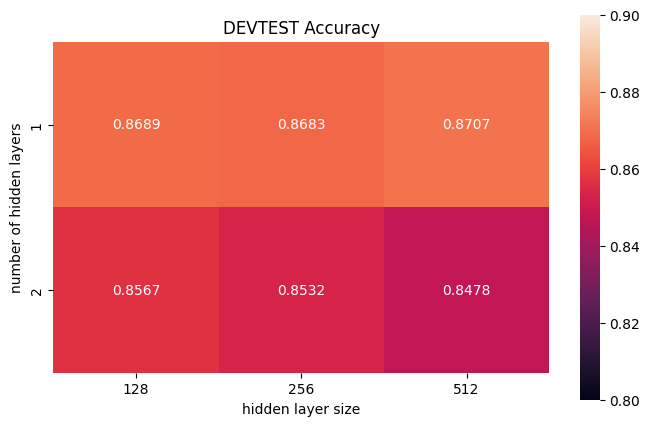

In [66]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.heatmap(devtest_evals_all,
            fmt='.4f',
            vmin=0.8,
            vmax=0.9,
            annot=True,
            square=True,
            xticklabels=['128', '256', '512'],
            yticklabels=['1', '2'],
            ax=ax)
ax.set_xlabel('hidden layer size')
ax.set_ylabel('number of hidden layers')
ax.set_title('DEVTEST Accuracy')

As shown in the figure above, models with 1 hidden layer performed better than models with 2 hidden layers for all three layer size options.   
For models with 1 hidden layer, model performance does not change much with the 3 different sizes of hidden layer, i.e., it stays at around 87%; although a layer size of 512 performed slightly better than layer sizes 128 and 256 in this iteration.   
However, for models with 2 hidden layers, model performance decreased with the increase of hidden layer sizes.

### nonlinearities

In this experiment, we will still use w=1, with one hidden layer of size 128, and fine-tuning pretrained embeddings.

In [68]:
devtest_evals_nonlin_all = []

nonlin = {'identity': nn.Identity(), 'tanh': nn.Tanh(), 'ReLU': nn.ReLU(), 'sigmoid': nn.Sigmoid()}


for nonlin_name, nonlin_func in nonlin.items():

    print(f'nonlinearity: {nonlin_name}')

    # instantiate model: single hidden layer 128, w=1, fine-tuned pretrained embedding
    tagger_w1_tunedpretrained_exp = FeedForwardNN(w=1, vocab_size=len(emb_pretrained_vocab), emb_dim=50, nfeatures=0,
                                    layer_sizes=[128, len(all_tags)],  # last layer is the output layer
                                    layer_acts=[nonlin_func, nn.Identity()],   # nn.CrossEntropyLoss() already includes softmax transformation
                                    pretrained_emb=emb_pretrained, emb_freeze=False)

    # instantiate optimizer
    sgd = optim.SGD(tagger_w1_tunedpretrained_exp.parameters(), lr=0.02)

    # train and eval
    epoch_losses, train_evals, dev_evals, devtest_eval = main_process(
                                              model=tagger_w1_tunedpretrained_exp,
                                              name='tagger_w1_tunedpretrained_'+nonlin_name,  # file name used for using checkpoint
                                              optimizer=sgd,
                                              criterion=nn.CrossEntropyLoss(),   # objective: log loss
                                              train_data=train_w1_30k,
                                              batch_size=1,
                                              shuffle=True,
                                              val_data=dev_w1_30k,
                                              test_data=devtest_w1_30k,
                                              max_epochs=20,
                                              early_stopping=3   # when dev eval doesn't improve for 3 consecutive epochs
                                          )
    devtest_evals_nonlin_all.append(devtest_eval)

    print(f'\n')

nonlinearity: identity
epoch 1
  epoch loss: 6145.1695303484885
  accuracy: 0.9746059544658494
  accuracy: 0.8450528935905414
  best model from epoch 1
epoch 2
  epoch loss: 1610.0183923154937
  accuracy: 0.9798598949211909
  accuracy: 0.8485791329599668
  best model from epoch 2
epoch 3
  epoch loss: 1442.9373112355054
  accuracy: 0.981903093987157
  accuracy: 0.840282099149554
  best model from epoch 2
epoch 4
  epoch loss: 1374.423037948443
  accuracy: 0.9800934033858727
  accuracy: 0.8344741754822651
  best model from epoch 2
epoch 5
  epoch loss: 1346.8888742349563
  accuracy: 0.9847635726795096
  accuracy: 0.8415266542211159
  best model from epoch 2
========= EARLY STOPPING =========
load best model
eval best model on devtest
  accuracy: 0.8486742832507006


nonlinearity: tanh
epoch 1
  epoch loss: 6033.632384385666
  accuracy: 0.973671920607122
  accuracy: 0.8458825969715826
  best model from epoch 1
epoch 2
  epoch loss: 1536.2270437387954
  accuracy: 0.9793345008756568
  accu

The table below shows the comparison of tagging performance with 4 different nonlinearities (Identity, Tanh, ReLU, Sigmoid). They performed similarly on DEV set; but sigmoid performed slightly better on DEVTEST set, followed by ReLU and Tanh.

| window size | hidden layer | hidden layer size | nonlinearity | best DEV accuracy | best epoch | DEVTEST accuracy |
| --- | --- | --- | --- | --- | --- | --- |
| 1 | 1 | 128 | Identity | 84.86% | 2 | 84.87% |
| 1 | 1 | 128 | Tanh | 84.59% | 1 | 85.38% |
| 1 | 1 | 128 | ReLU | 84.75% | 5 | 85.54% |
| 1 | 1 | 128 | Sigmoid | 84.61% | 2 | 85.71% |